In [2]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.misc import imread
from scipy.misc import imresize
from PIL import Image
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_Pandora18K(data_dir = '../dataset/Pandora_18k_flat_and_resized'):
    
    i = 0
    X_data = []
    Y_data = []
    
    for root, dirs, files in os.walk(data_dir):
        path = root.split(os.sep)
        for file in files:
            if '.jpg' in str(file).lower(): # an image file
                file_path = os.path.join(root,file)

                # Get image
                imagedata = imread(file_path)
                assert imagedata.shape == (500, 500, 3)
                X_data.append(imagedata)
                
                # Get class
                correct_class = -1
                if "01_Byzantin_Iconography" in root:
                    correct_class = 1
                elif "02_Early_Renaissance" in root:
                    correct_class = 2
                elif "03_Northern_Renaissance" in root:
                    correct_class = 3
                elif "04_High_Renaissance" in root:
                    correct_class = 4
                elif "05_Baroque" in root:
                    correct_class = 5
                elif "06_Rococo" in root:
                    correct_class = 6
                elif "07_Romanticism" in root:
                    correct_class = 7
                elif "08_Realism" in root:
                    correct_class = 8
                elif "09_Impressionism" in root:
                    correct_class = 9
                elif "10_Post_Impressionism" in root:
                    correct_class = 10
                elif "11_Expressionism" in root:
                    correct_class = 11
                elif "12_Symbolism" in root:
                    correct_class = 12
                elif "13_Fauvism" in root:
                    correct_class = 13
                elif "14_Cubism" in root:
                    correct_class = 14
                elif "15_Surrealism" in root:
                    correct_class = 15
                elif "16_AbstractArt" in root:
                    correct_class = 16
                elif "17_NaiveArt" in root:
                    correct_class = 17
                elif "18_PopArt" in root:
                    correct_class = 18
                
                assert correct_class != -1
                Y_data.append(correct_class)
                
                """
                i = i + 1

                if i >= 30: #this should be all of them, do the shuffling and subsampling below
                    X_data_arr = np.array(X_data)
                    Y_data_arr = np.array(Y_data)
                    return X_data_arr, Y_data_arr
                """
    X_data_arr = np.array(X_data)
    Y_data_arr = np.array(Y_data)
    return X_data_arr, Y_data_arr


In [4]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

data_dir = '../dataset/Pandora_18k_flat_and_resized'
#17876 images total

#grab data
print("Loading Pandora18k data...")
X_data, Y_data = load_Pandora18K(data_dir)

#shuffle x and y data together
print("Shuffling Pandora18k data...")
X_data, Y_data = unison_shuffled_copies(X_data, Y_data)

print(Y_data[0:10])

print("X_data.shape")
print(X_data.shape)
print("Y_data.shape")
print(Y_data.shape)

Loading Pandora18k data...
Shuffling Pandora18k data...
[12 10  1  8 12  5  3 14  6 16]
X_data.shape
(17876, 500, 500, 3)
Y_data.shape
(17876,)


In [26]:
#def get_data(num_training=8000, num_validation=1876, num_test=8000): 
def sub_sample_data(num_training=2, num_validation=500, num_test=500): #test with 300 images total
    
    #training data subsample
    print("Subsampling training...")
    mask = range(0, num_training)
    X_train = X_data[mask]
    y_train = Y_data[mask]
    
    #validation data subsample
    print("Subsampling validation...")
    mask = range(num_training, num_training + num_validation)
    X_val = X_data[mask]
    y_val = Y_data[mask]
    
    #test data subsample
    print("Subsampling test...")
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X_data[mask]
    y_test = Y_data[mask]
    
    """
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    """

    return X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
print("calling get_data()...")
X_train, y_train, X_val, y_val, X_test, y_test = sub_sample_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

calling get_data()...
Subsampling training...
Subsampling validation...
Subsampling test...
Train data shape:  (2, 500, 500, 3)
Train labels shape:  (2,)
Validation data shape:  (500, 500, 500, 3)
Validation labels shape:  (500,)
Test data shape:  (500, 500, 500, 3)
Test labels shape:  (500,)


In [27]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 500, 500, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def style_model(img, y):
    """Generate class scores for img
    
    Inputs:
    - img: Tensor of image [batch_size, 500, 500, 3]
    - y: class [batch_size, 18]
    
    Returns:
    Class scores [batch_size, 18].
    """
    
    dims = tf.shape(img)
    batch_size = dims[0]
    
    conv1 = tf.layers.conv2d(
        inputs=img,
        filters=4,
        kernel_size=[10, 10],
        strides = [10,10],
        padding="valid",
        activation=tf.nn.relu)
    
    print(conv1)
    
    flat = tf.reshape(conv1, [batch_size, 10000]) #50 * 50 * 4
    
    dense = tf.layers.dense(inputs=flat, units=18)

    return dense

y_out = style_model(X, y)

# define our loss
total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
#optimizer = tf.train.AdamOptimizer(5e-18) # select optimizer and set learning rate
#train_step = optimizer.minimize(mean_loss)



g_step = tf.Variable(0, trainable=False)
learning_rate = 5e-18#tf.train.exponential_decay(5e-18, g_step,int(40000)/2, self.config.flag.step_decay_rate, staircase=True)

optimizer = tf.train.AdamOptimizer(5e-18)
tuples = optimizer.compute_gradients(mean_loss)
grads = [entry[0] for entry in tuples]
vars = [entry[1] for entry in tuples]
outGrad = tf.global_norm(grads)        # FOR DEBUGGING
grads, _ = tf.clip_by_global_norm(grads, 10)
clipped_gradients = zip(grads, vars)
learning_rate = learning_rate          # FOR DEBUGGING
train_step = optimizer.apply_gradients(clipped_gradients, global_step=g_step)

Tensor("conv2d/Relu:0", shape=(?, 50, 50, 4), dtype=float32)


Training
Iteration 0: with minibatch training loss = 193 and accuracy of 0
Epoch 1, Overall loss = 193 and accuracy of 0


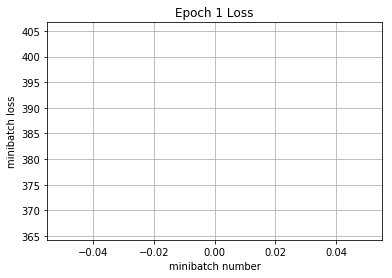

Iteration 1: with minibatch training loss = 193 and accuracy of 0
Epoch 2, Overall loss = 193 and accuracy of 0


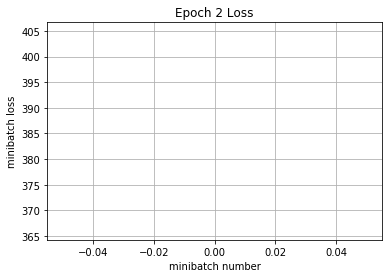

Iteration 2: with minibatch training loss = 193 and accuracy of 0
Epoch 3, Overall loss = 193 and accuracy of 0


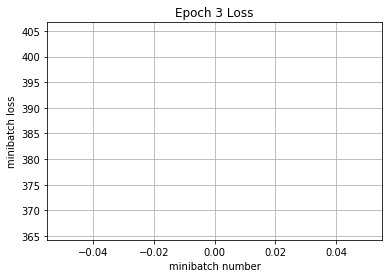

Iteration 3: with minibatch training loss = 193 and accuracy of 0
Epoch 4, Overall loss = 193 and accuracy of 0


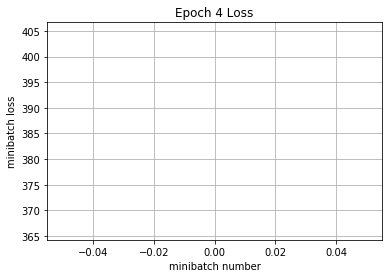

Iteration 4: with minibatch training loss = 193 and accuracy of 0
Epoch 5, Overall loss = 193 and accuracy of 0


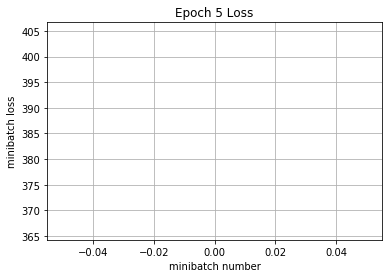

Iteration 5: with minibatch training loss = 193 and accuracy of 0
Epoch 6, Overall loss = 193 and accuracy of 0


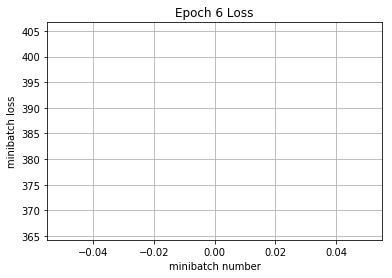

Iteration 6: with minibatch training loss = 193 and accuracy of 0
Epoch 7, Overall loss = 193 and accuracy of 0


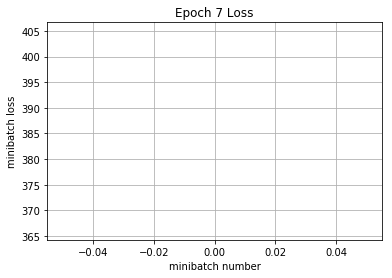

Iteration 7: with minibatch training loss = 193 and accuracy of 0
Epoch 8, Overall loss = 193 and accuracy of 0


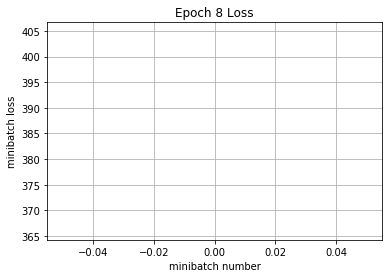

Iteration 8: with minibatch training loss = 193 and accuracy of 0
Epoch 9, Overall loss = 193 and accuracy of 0


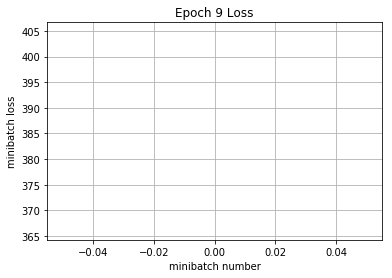

Iteration 9: with minibatch training loss = 193 and accuracy of 0
Epoch 10, Overall loss = 193 and accuracy of 0


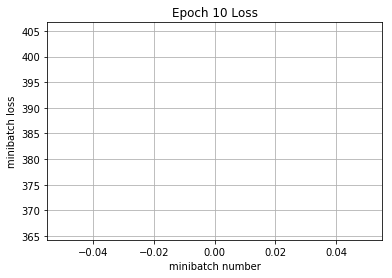

Iteration 10: with minibatch training loss = 193 and accuracy of 0
Epoch 11, Overall loss = 193 and accuracy of 0


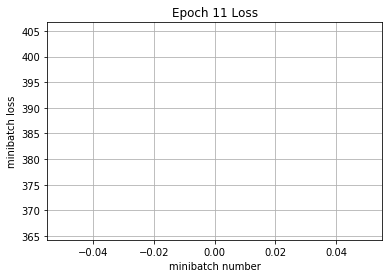

Iteration 11: with minibatch training loss = 193 and accuracy of 0
Epoch 12, Overall loss = 193 and accuracy of 0


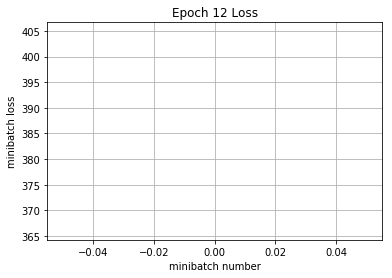

Iteration 12: with minibatch training loss = 193 and accuracy of 0
Epoch 13, Overall loss = 193 and accuracy of 0


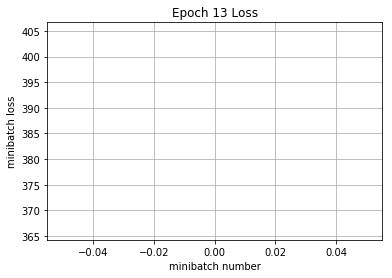

Iteration 13: with minibatch training loss = 193 and accuracy of 0
Epoch 14, Overall loss = 193 and accuracy of 0


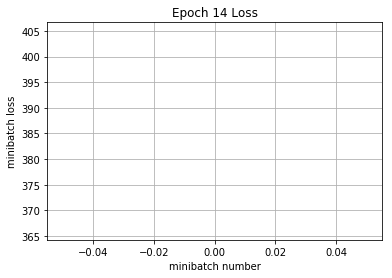

Iteration 14: with minibatch training loss = 193 and accuracy of 0
Epoch 15, Overall loss = 193 and accuracy of 0


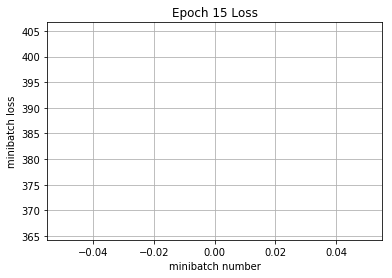

Iteration 15: with minibatch training loss = 193 and accuracy of 0
Epoch 16, Overall loss = 193 and accuracy of 0


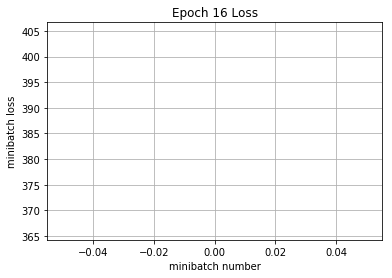

Iteration 16: with minibatch training loss = 193 and accuracy of 0
Epoch 17, Overall loss = 193 and accuracy of 0


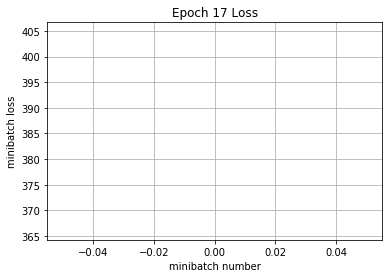

Iteration 17: with minibatch training loss = 193 and accuracy of 0
Epoch 18, Overall loss = 193 and accuracy of 0


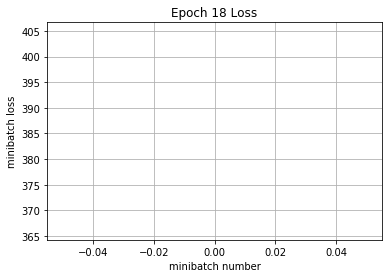

Iteration 18: with minibatch training loss = 193 and accuracy of 0
Epoch 19, Overall loss = 193 and accuracy of 0


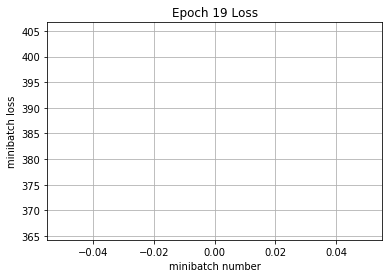

Iteration 19: with minibatch training loss = 193 and accuracy of 0
Epoch 20, Overall loss = 193 and accuracy of 0


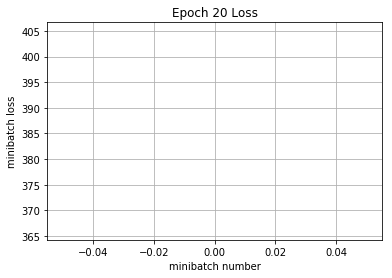

Iteration 20: with minibatch training loss = 193 and accuracy of 0
Epoch 21, Overall loss = 193 and accuracy of 0


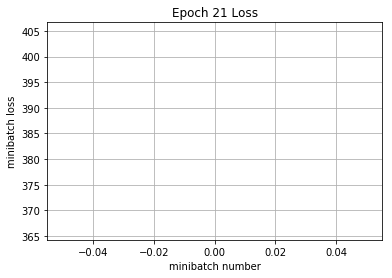

Iteration 21: with minibatch training loss = 193 and accuracy of 0
Epoch 22, Overall loss = 193 and accuracy of 0


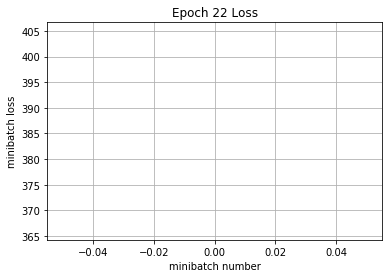

Iteration 22: with minibatch training loss = 193 and accuracy of 0
Epoch 23, Overall loss = 193 and accuracy of 0


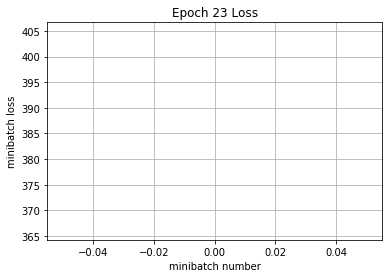

Iteration 23: with minibatch training loss = 193 and accuracy of 0
Epoch 24, Overall loss = 193 and accuracy of 0


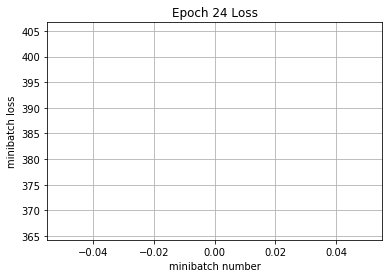

Iteration 24: with minibatch training loss = 193 and accuracy of 0
Epoch 25, Overall loss = 193 and accuracy of 0


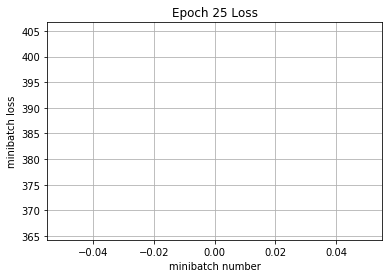

Iteration 25: with minibatch training loss = 193 and accuracy of 0
Epoch 26, Overall loss = 193 and accuracy of 0


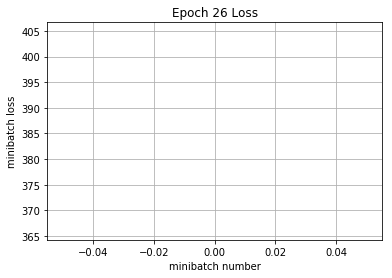

Iteration 26: with minibatch training loss = 193 and accuracy of 0
Epoch 27, Overall loss = 193 and accuracy of 0


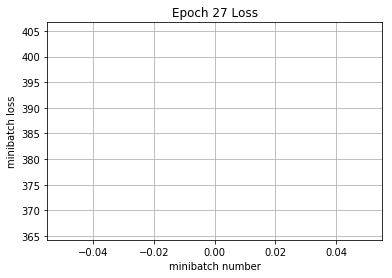

Iteration 27: with minibatch training loss = 193 and accuracy of 0
Epoch 28, Overall loss = 193 and accuracy of 0


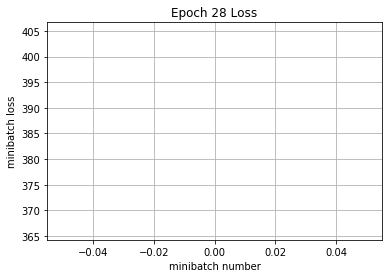

Iteration 28: with minibatch training loss = 193 and accuracy of 0
Epoch 29, Overall loss = 193 and accuracy of 0


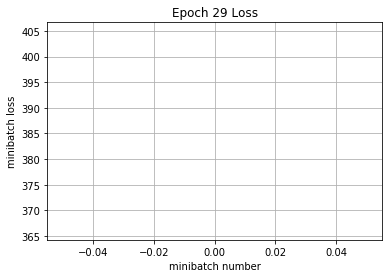

Iteration 29: with minibatch training loss = 193 and accuracy of 0
Epoch 30, Overall loss = 193 and accuracy of 0


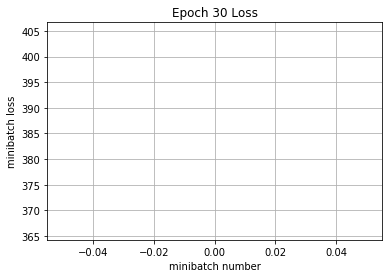

Iteration 30: with minibatch training loss = 193 and accuracy of 0
Epoch 31, Overall loss = 193 and accuracy of 0


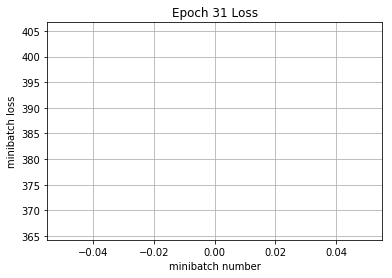

Iteration 31: with minibatch training loss = 193 and accuracy of 0
Epoch 32, Overall loss = 193 and accuracy of 0


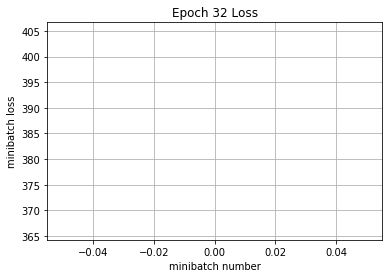

Iteration 32: with minibatch training loss = 193 and accuracy of 0
Epoch 33, Overall loss = 193 and accuracy of 0


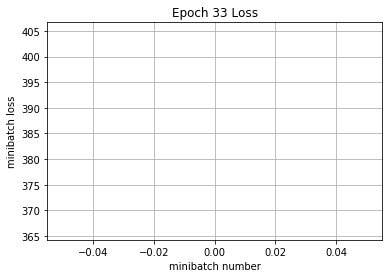

Iteration 33: with minibatch training loss = 193 and accuracy of 0
Epoch 34, Overall loss = 193 and accuracy of 0


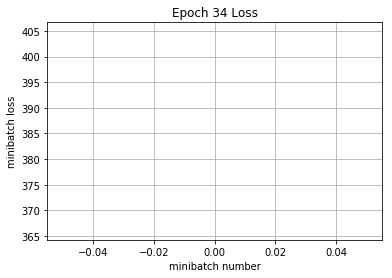

Iteration 34: with minibatch training loss = 193 and accuracy of 0
Epoch 35, Overall loss = 193 and accuracy of 0


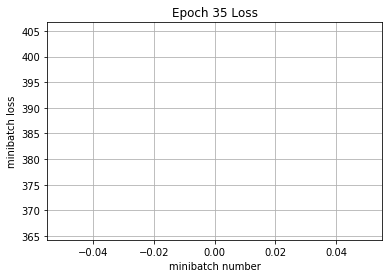

Iteration 35: with minibatch training loss = 193 and accuracy of 0
Epoch 36, Overall loss = 193 and accuracy of 0


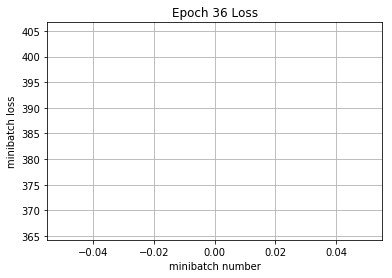

Iteration 36: with minibatch training loss = 193 and accuracy of 0
Epoch 37, Overall loss = 193 and accuracy of 0


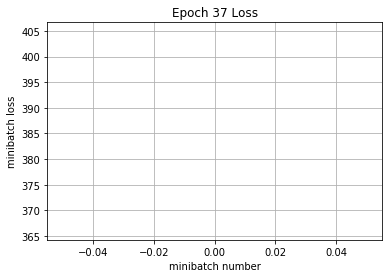

Iteration 37: with minibatch training loss = 193 and accuracy of 0
Epoch 38, Overall loss = 193 and accuracy of 0


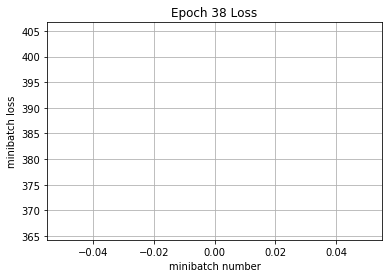

Iteration 38: with minibatch training loss = 193 and accuracy of 0
Epoch 39, Overall loss = 193 and accuracy of 0


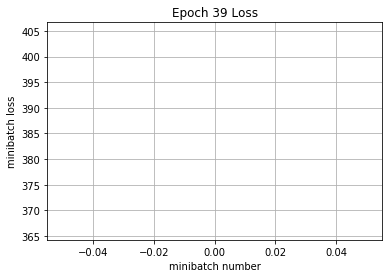

Iteration 39: with minibatch training loss = 193 and accuracy of 0
Epoch 40, Overall loss = 193 and accuracy of 0


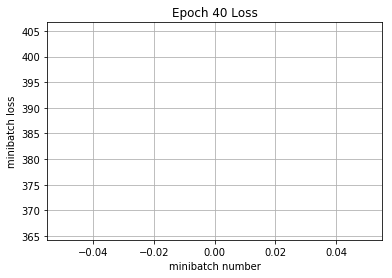

Iteration 40: with minibatch training loss = 193 and accuracy of 0
Epoch 41, Overall loss = 193 and accuracy of 0


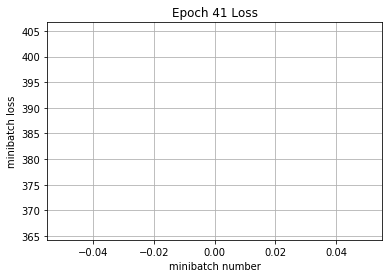

Iteration 41: with minibatch training loss = 193 and accuracy of 0
Epoch 42, Overall loss = 193 and accuracy of 0


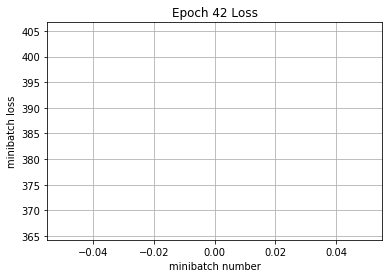

Iteration 42: with minibatch training loss = 193 and accuracy of 0
Epoch 43, Overall loss = 193 and accuracy of 0


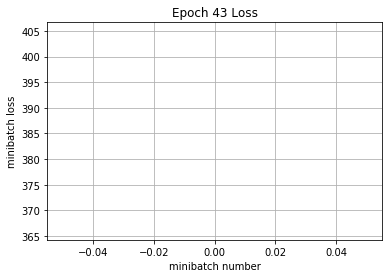

Iteration 43: with minibatch training loss = 193 and accuracy of 0
Epoch 44, Overall loss = 193 and accuracy of 0


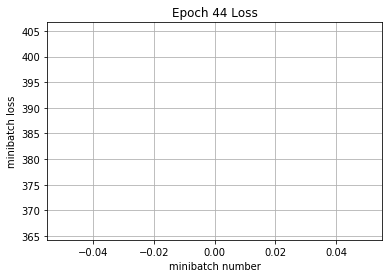

Iteration 44: with minibatch training loss = 193 and accuracy of 0
Epoch 45, Overall loss = 193 and accuracy of 0


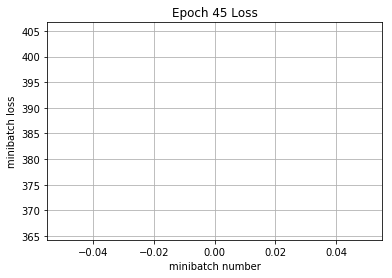

Iteration 45: with minibatch training loss = 193 and accuracy of 0
Epoch 46, Overall loss = 193 and accuracy of 0


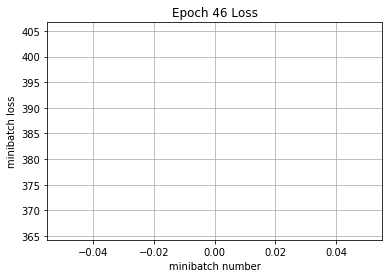

Iteration 46: with minibatch training loss = 193 and accuracy of 0
Epoch 47, Overall loss = 193 and accuracy of 0


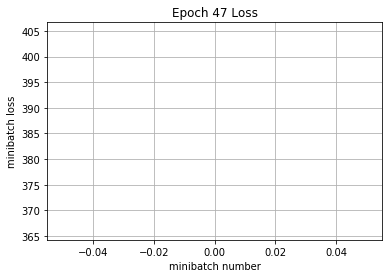

Iteration 47: with minibatch training loss = 193 and accuracy of 0
Epoch 48, Overall loss = 193 and accuracy of 0


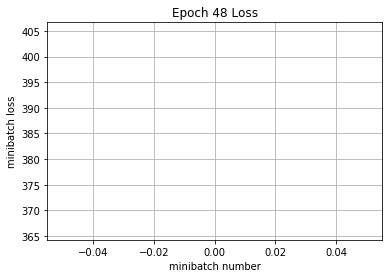

Iteration 48: with minibatch training loss = 193 and accuracy of 0
Epoch 49, Overall loss = 193 and accuracy of 0


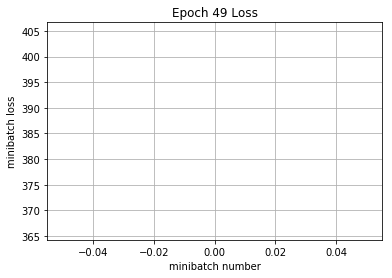

Iteration 49: with minibatch training loss = 193 and accuracy of 0
Epoch 50, Overall loss = 193 and accuracy of 0


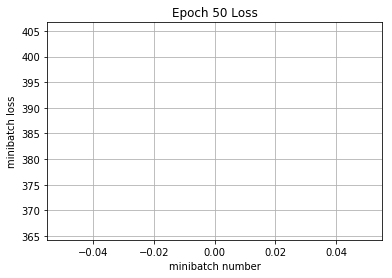

Iteration 50: with minibatch training loss = 193 and accuracy of 0
Epoch 51, Overall loss = 193 and accuracy of 0


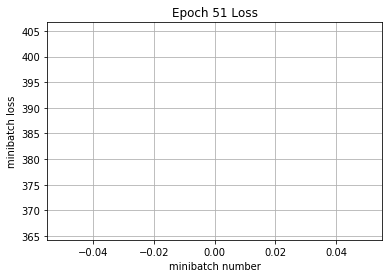

Iteration 51: with minibatch training loss = 193 and accuracy of 0
Epoch 52, Overall loss = 193 and accuracy of 0


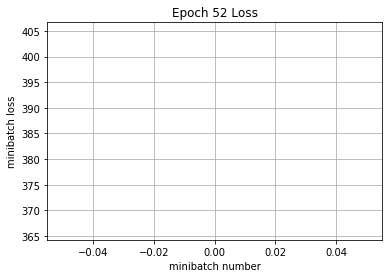

Iteration 52: with minibatch training loss = 193 and accuracy of 0
Epoch 53, Overall loss = 193 and accuracy of 0


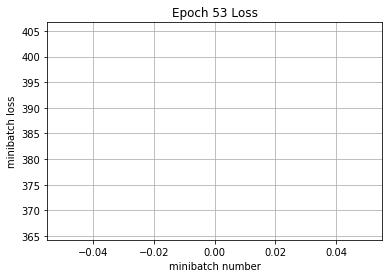

Iteration 53: with minibatch training loss = 193 and accuracy of 0
Epoch 54, Overall loss = 193 and accuracy of 0


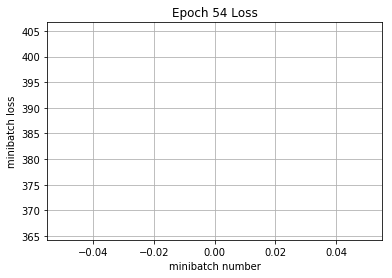

Iteration 54: with minibatch training loss = 193 and accuracy of 0
Epoch 55, Overall loss = 193 and accuracy of 0


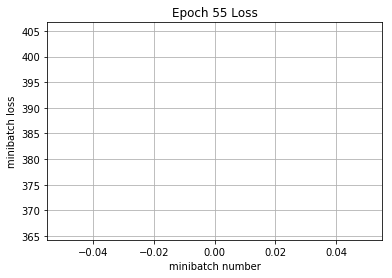

Iteration 55: with minibatch training loss = 193 and accuracy of 0
Epoch 56, Overall loss = 193 and accuracy of 0


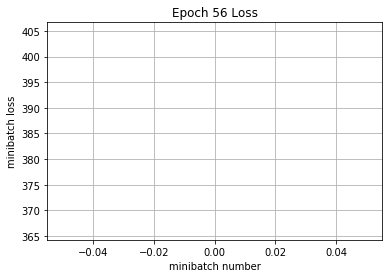

Iteration 56: with minibatch training loss = 193 and accuracy of 0
Epoch 57, Overall loss = 193 and accuracy of 0


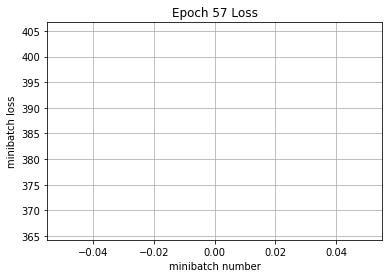

Iteration 57: with minibatch training loss = 193 and accuracy of 0
Epoch 58, Overall loss = 193 and accuracy of 0


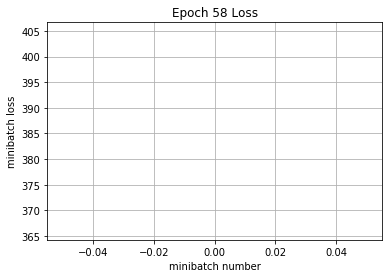

Iteration 58: with minibatch training loss = 193 and accuracy of 0
Epoch 59, Overall loss = 193 and accuracy of 0


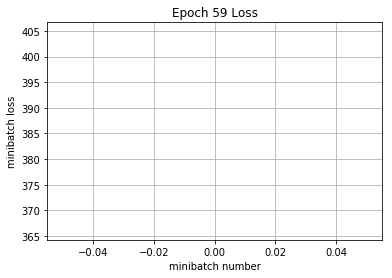

Iteration 59: with minibatch training loss = 193 and accuracy of 0
Epoch 60, Overall loss = 193 and accuracy of 0


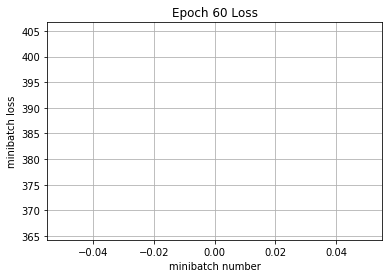

Iteration 60: with minibatch training loss = 193 and accuracy of 0
Epoch 61, Overall loss = 193 and accuracy of 0


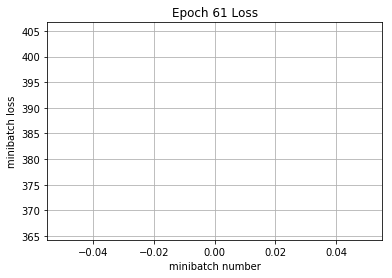

Iteration 61: with minibatch training loss = 193 and accuracy of 0
Epoch 62, Overall loss = 193 and accuracy of 0


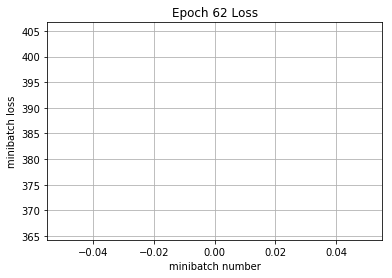

Iteration 62: with minibatch training loss = 193 and accuracy of 0
Epoch 63, Overall loss = 193 and accuracy of 0


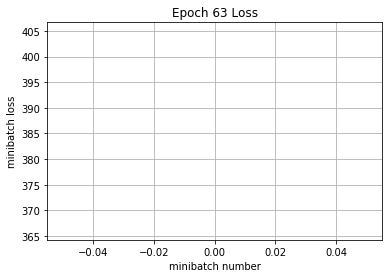

Iteration 63: with minibatch training loss = 193 and accuracy of 0
Epoch 64, Overall loss = 193 and accuracy of 0


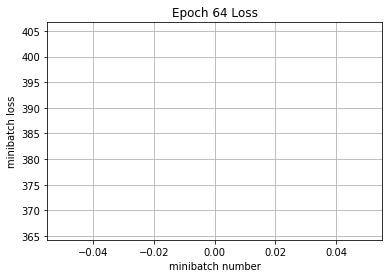

Iteration 64: with minibatch training loss = 193 and accuracy of 0
Epoch 65, Overall loss = 193 and accuracy of 0


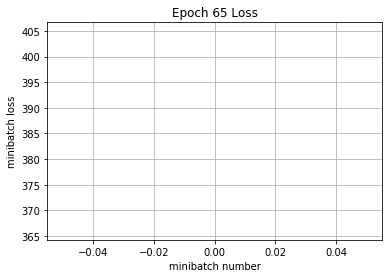

Iteration 65: with minibatch training loss = 193 and accuracy of 0
Epoch 66, Overall loss = 193 and accuracy of 0


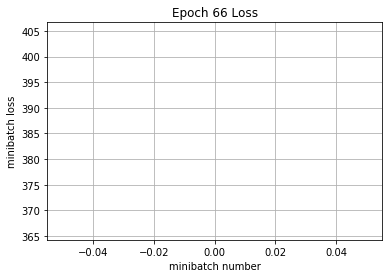

Iteration 66: with minibatch training loss = 193 and accuracy of 0
Epoch 67, Overall loss = 193 and accuracy of 0


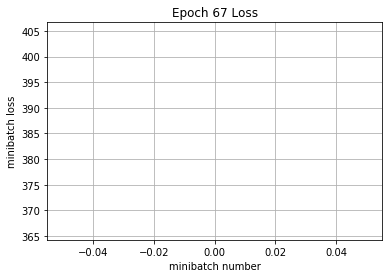

Iteration 67: with minibatch training loss = 193 and accuracy of 0
Epoch 68, Overall loss = 193 and accuracy of 0


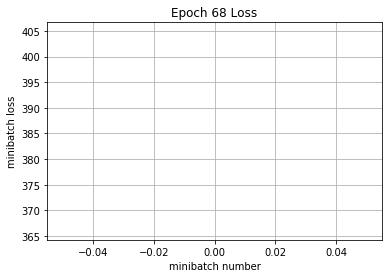

Iteration 68: with minibatch training loss = 193 and accuracy of 0
Epoch 69, Overall loss = 193 and accuracy of 0


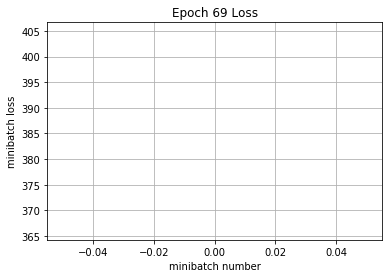

Iteration 69: with minibatch training loss = 193 and accuracy of 0
Epoch 70, Overall loss = 193 and accuracy of 0


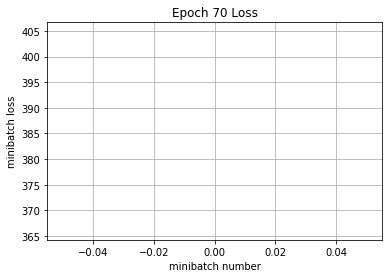

Iteration 70: with minibatch training loss = 193 and accuracy of 0
Epoch 71, Overall loss = 193 and accuracy of 0


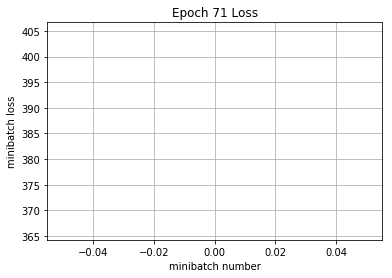

Iteration 71: with minibatch training loss = 193 and accuracy of 0
Epoch 72, Overall loss = 193 and accuracy of 0


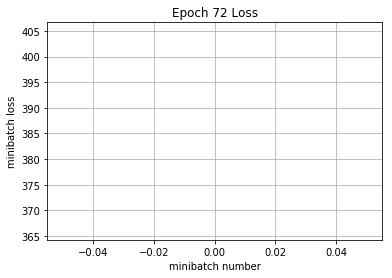

Iteration 72: with minibatch training loss = 193 and accuracy of 0
Epoch 73, Overall loss = 193 and accuracy of 0


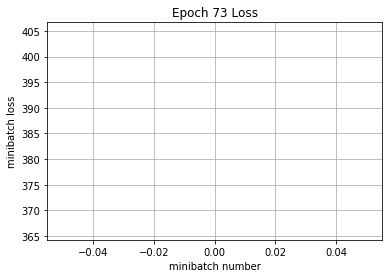

Iteration 73: with minibatch training loss = 193 and accuracy of 0
Epoch 74, Overall loss = 193 and accuracy of 0


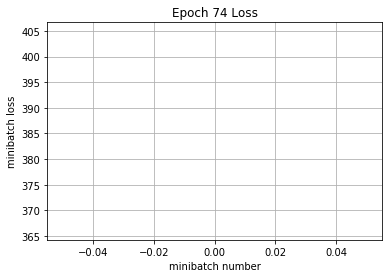

Iteration 74: with minibatch training loss = 193 and accuracy of 0
Epoch 75, Overall loss = 193 and accuracy of 0


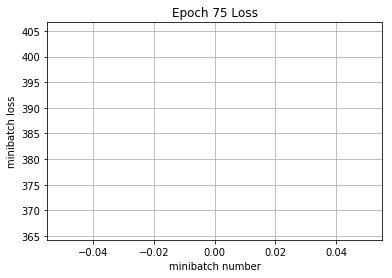

Iteration 75: with minibatch training loss = 193 and accuracy of 0
Epoch 76, Overall loss = 193 and accuracy of 0


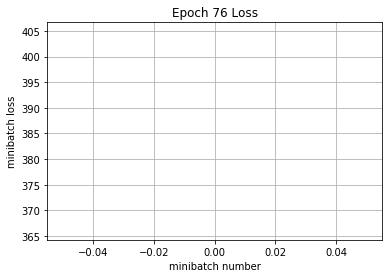

Iteration 76: with minibatch training loss = 193 and accuracy of 0
Epoch 77, Overall loss = 193 and accuracy of 0


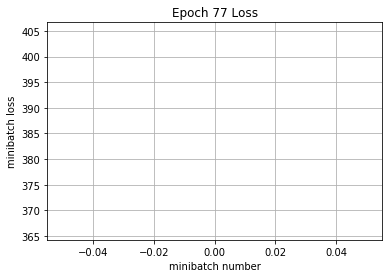

Iteration 77: with minibatch training loss = 193 and accuracy of 0
Epoch 78, Overall loss = 193 and accuracy of 0


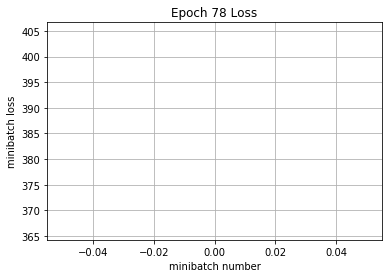

Iteration 78: with minibatch training loss = 193 and accuracy of 0
Epoch 79, Overall loss = 193 and accuracy of 0


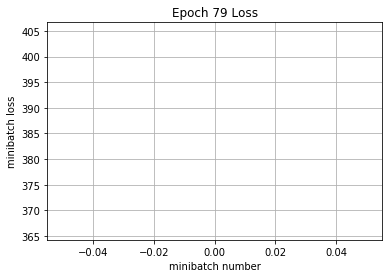

Iteration 79: with minibatch training loss = 193 and accuracy of 0
Epoch 80, Overall loss = 193 and accuracy of 0


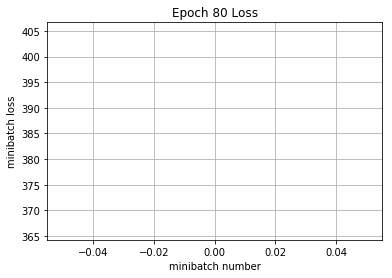

Iteration 80: with minibatch training loss = 193 and accuracy of 0
Epoch 81, Overall loss = 193 and accuracy of 0


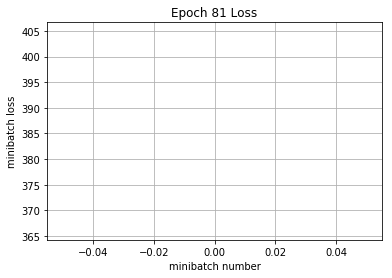

Iteration 81: with minibatch training loss = 193 and accuracy of 0
Epoch 82, Overall loss = 193 and accuracy of 0


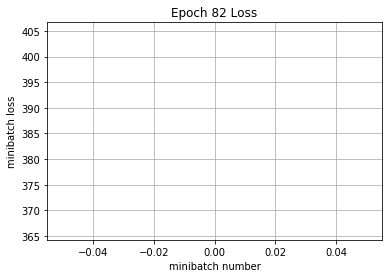

Iteration 82: with minibatch training loss = 193 and accuracy of 0
Epoch 83, Overall loss = 193 and accuracy of 0


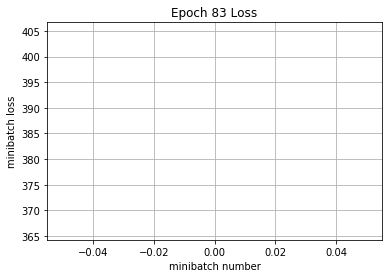

Iteration 83: with minibatch training loss = 193 and accuracy of 0
Epoch 84, Overall loss = 193 and accuracy of 0


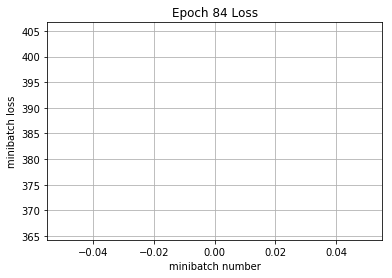

Iteration 84: with minibatch training loss = 193 and accuracy of 0
Epoch 85, Overall loss = 193 and accuracy of 0


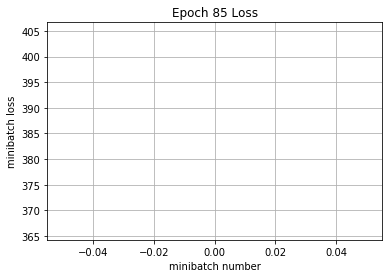

Iteration 85: with minibatch training loss = 193 and accuracy of 0
Epoch 86, Overall loss = 193 and accuracy of 0


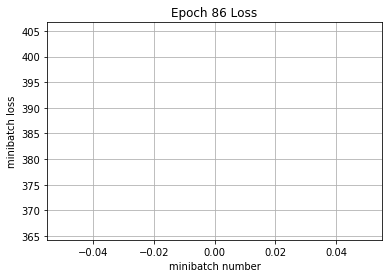

Iteration 86: with minibatch training loss = 193 and accuracy of 0
Epoch 87, Overall loss = 193 and accuracy of 0


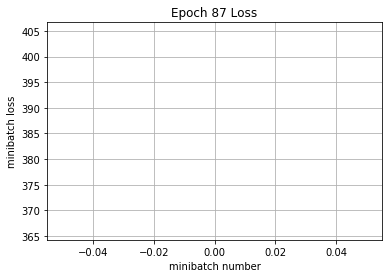

Iteration 87: with minibatch training loss = 193 and accuracy of 0
Epoch 88, Overall loss = 193 and accuracy of 0


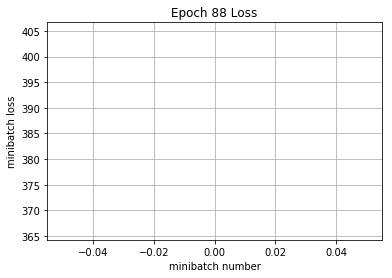

Iteration 88: with minibatch training loss = 193 and accuracy of 0
Epoch 89, Overall loss = 193 and accuracy of 0


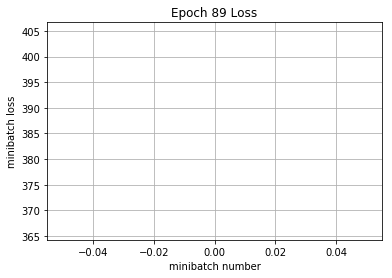

Iteration 89: with minibatch training loss = 193 and accuracy of 0
Epoch 90, Overall loss = 193 and accuracy of 0


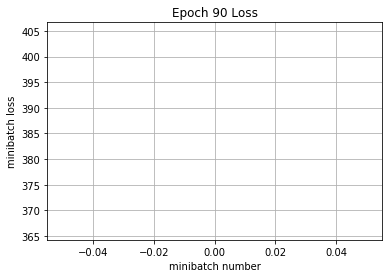

Iteration 90: with minibatch training loss = 193 and accuracy of 0
Epoch 91, Overall loss = 193 and accuracy of 0


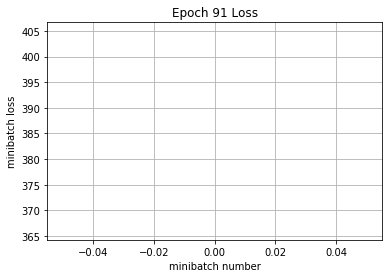

Iteration 91: with minibatch training loss = 193 and accuracy of 0
Epoch 92, Overall loss = 193 and accuracy of 0


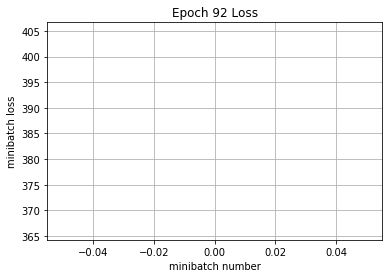

Iteration 92: with minibatch training loss = 193 and accuracy of 0
Epoch 93, Overall loss = 193 and accuracy of 0


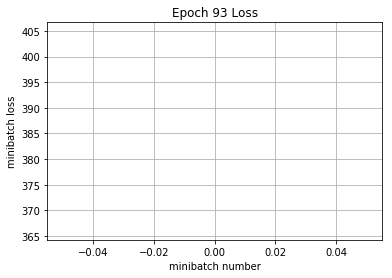

Iteration 93: with minibatch training loss = 193 and accuracy of 0
Epoch 94, Overall loss = 193 and accuracy of 0


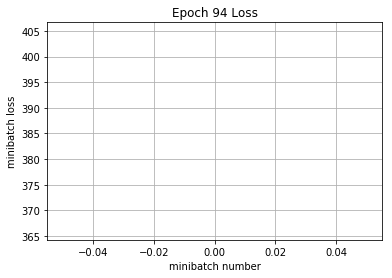

Iteration 94: with minibatch training loss = 193 and accuracy of 0
Epoch 95, Overall loss = 193 and accuracy of 0


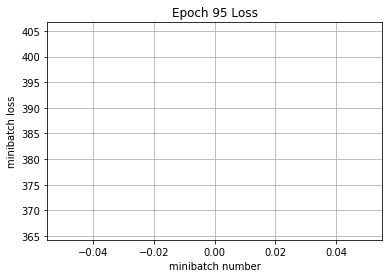

Iteration 95: with minibatch training loss = 193 and accuracy of 0
Epoch 96, Overall loss = 193 and accuracy of 0


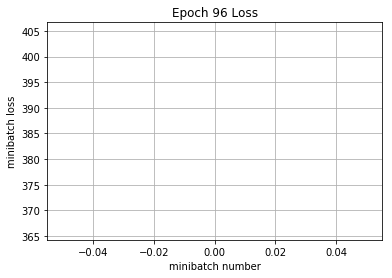

Iteration 96: with minibatch training loss = 193 and accuracy of 0
Epoch 97, Overall loss = 193 and accuracy of 0


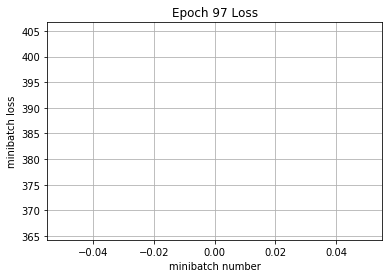

Iteration 97: with minibatch training loss = 193 and accuracy of 0
Epoch 98, Overall loss = 193 and accuracy of 0


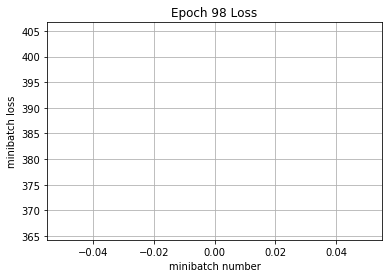

Iteration 98: with minibatch training loss = 193 and accuracy of 0
Epoch 99, Overall loss = 193 and accuracy of 0


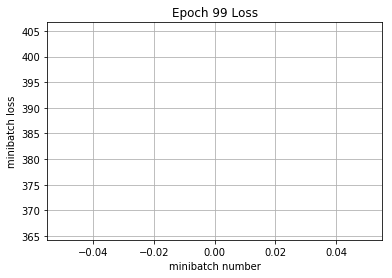

Iteration 99: with minibatch training loss = 193 and accuracy of 0
Epoch 100, Overall loss = 193 and accuracy of 0


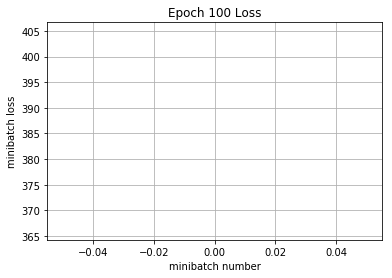

Validation
Epoch 1, Overall loss = 51.3 and accuracy of 0
Test
Epoch 1, Overall loss = 110 and accuracy of 0


In [29]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs, batch_size, print_every=5,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

my_batch_size = 2
train_num_epochs = 100


with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,train_num_epochs,my_batch_size,1,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,my_batch_size)
        print('Test')
        run_model(sess,y_out,mean_loss,X_test,y_test,1,my_batch_size)